In [624]:
import numpy.random as random
import scipy.stats as stats
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

In [625]:
def getNoise(N):
    return np.random.randn(N)

def calcFFT(x):
    X = np.fft.fft(x)
    f = np.fft.fftfreq(len(x))
    return X, f


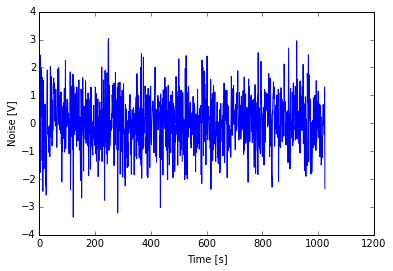

In [626]:
N = 2048
T = 2048
dt = T/N
t=np.arange(0,T,dt)

noise = getNoise(N/2)
plt.plot(np.linspace(0,N/2,N/2),noise)
plt.xlabel('Time [s]');plt.ylabel('Noise [V]')
plt.show()

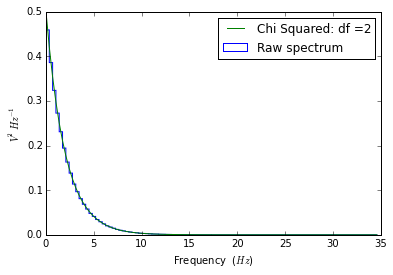

In [640]:
NN = 1000
Gxx = np.ndarray((NN,(N)))
for ind in range(NN):
    noise = getNoise(N)
    noiseFFT, noiseFreq = calcFFT(noise)
    noisePS = np.real(noiseFFT*np.conj(noiseFFT)/T)
    Gxx[ind,:] = noisePS
    
Gxx = Gxx.flatten()
Gxx = Gxx*2
n, bins, z = plt.hist(Gxx,100,histtype = 'step',normed = True, label = 'Raw spectrum')

chi2 = stats.chi2.pdf(bins, 2)
plt.plot(bins, chi2,label = 'Chi Squared: df =2')
plt.xlabel('Frequency  ($Hz$)')
plt.ylabel('$V^2Hz^{-1}$')
plt.legend()


8.0


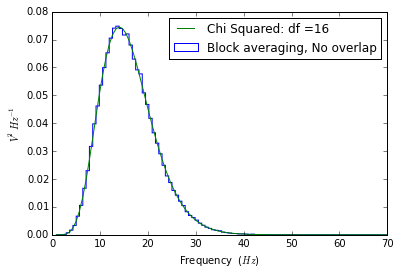

In [644]:
print nblock
def blocks(noise,NFFT):
    N = len(noise)
    nblock = np.floor(N/NFFT)
    noiseAvg = np.zeros(NFFT)

    for ind in range(int(nblock)):
        inds = range(ind*NFFT,(ind+1)*NFFT)
        tblock = t[inds]
        noiseblock = noise[inds]
        nblockFFT, nblockfreq = calcFFT(noiseblock)
        nblockPS = 2*np.real(nblockFFT*np.conj(nblockFFT))/len(nblockFFT)
        noiseAvg = noiseAvg + nblockPS[0:NFFT]

    return noiseAvg/nblock, nblock


NN = 1000
NFFT = 256
Gxx = np.ndarray((NN,NFFT))
for ind in range(NN):
    noise = getNoise(N)
    noisePS, nblock = blocks(noise,NFFT)
    Gxx[ind,:] = noisePS
    
Gxx = Gxx.flatten()
Gxx = Gxx*nblock
n, bins, z = plt.hist(Gxx,100,histtype = 'step',normed = True, label = 'Block averaging, No overlap')

chi2 = stats.chi2.pdf(bins, 2*nblock)
plt.plot(bins, chi2,label = 'Chi Squared: df ={}'.format(int(2*nblock)))
plt.xlabel('Frequency  ($Hz$)')
plt.ylabel('$V^2Hz^{-1}$')
plt.legend()

In [629]:
def hanning(noise, NFFT):
    N = len(noise)
    nblock = np.floor(N/int(NFFT*0.75))
    noiseAvg = np.zeros(NFFT)
    
    for ind in range(int(nblock)):
        inds = range(int(np.floor(0.75*ind*NFFT)), int(np.floor(0.75*ind*NFFT+NFFT)))
        tblock = t[inds]
        noiseblock = noise[inds]
        nblockFFT, nblockfreq = calcFFT(noiseblock)
        nblockPS = 2*np.real(nblockFFT*np.conj(nblockFFT))/len(nblockFFT)
        noiseAvg = noiseAvg + nblockPS[0:NFFT]

    return noiseAvg/nblock, nblock
        
        


20.0


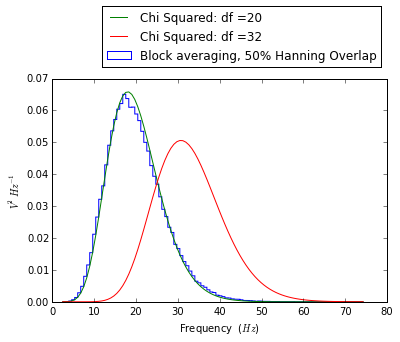

In [655]:
NN = 1000
NFFT = 256
Gxx = np.ndarray((NN,NFFT))
for ind in range(NN):
    noise = getNoise(N)
    noisePS, nblock = hanning(noise,NFFT)
    Gxx[ind,:] = noisePS
    
Gxx = Gxx.flatten()
Gxx = Gxx*nblock
n, bins, z = plt.hist(Gxx,100,histtype = 'step',normed = True, label = 'Block averaging, 50% Hanning Overlap')
print 2*nblock
chi2 = stats.chi2.pdf(bins, 2*nblock)
plt.plot(bins, chi2,label = 'Chi Squared: df ={}'.format(int(2*nblock)))
chi2 = stats.chi2.pdf(bins, 2.*18.*nblock/11)
plt.plot(bins, chi2,label = 'Chi Squared: df ={}'.format(int(2.*18.*nblock/11)))
plt.xlabel('Frequency  ($Hz$)')
plt.ylabel('$V^2Hz^{-1}$')
plt.legend(bbox_to_anchor=(1, 1.35))

The data matched reasonably well for $2*N_{block}$ but not for $2*\frac{18}{11}N_{Block}$

**Q2: Spectra of a "red-noise" signal**
**1** Load in the Deep Cove hourly data, and compute the power spectra using some reasonable value for NFFT, and comment on the effect of applying the Hanning window to not applying it to the spectral leakage.

In [631]:
hourdata=np.genfromtxt('http://web.uvic.ca/~jklymak/Phy411/Data/AllHourly.txt')[[6,28],2:]
dc = hourdata[0,:]
dc=dc[np.isfinite(dc)]
dc = dc-np.mean(dc)

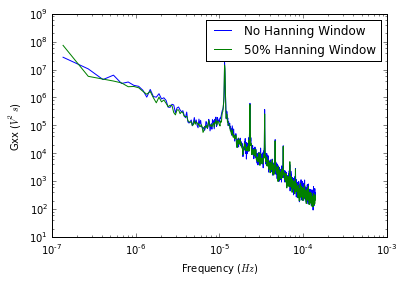

In [632]:
nfft = 2048
GxxRaw, freq = mlab.psd(dc, Fs=1./3600, window=mlab.window_none, NFFT=nfft)
GxxHan, freq = mlab.psd(dc, NFFT = nfft, Fs = 1./3600, noverlap = nfft/2)

plt.loglog(freq, GxxRaw, label='No Hanning Window')
plt.loglog(freq, GxxHan, label='50% Hanning Window')
plt.ylabel(r'Gxx ($V^2 s$)')
plt.xlabel('Frequency ($Hz$)')
plt.legend()

The use of the hanning windows reduces the ammout of noise whn looking at the power spectrum.

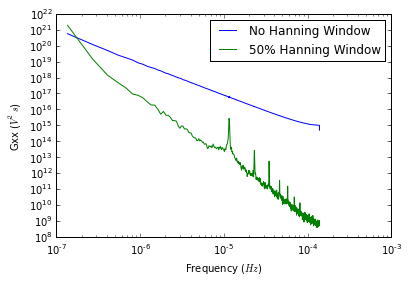

In [633]:
dcsum = np.cumsum(dc)*3600

GxxRaw_y, freq2  = mlab.psd(dcsum, Fs=1./3600, window=mlab.window_none, NFFT=nfft)
GxxHan_y, freq2 = mlab.psd(dcsum, NFFT = nfft, Fs = 1./3600, noverlap = nfft/2)
plt.loglog(freq2, GxxRaw_y, label='No Hanning Window')
plt.loglog(freq2, GxxHan_y, label='50% Hanning Window')
plt.ylabel(r'Gxx ($V^2 s$)')
plt.xlabel('Frequency ($Hz$)')
plt.legend()

The use of Hanning windows here allowed us to see the peaks if frequency that were otherwise not visible